# Vibration of Unbalance Rotating Shaft Classification with CNN

## Step 0 - Set up
### Import TensorFlow and Other Libraries

In [1]:
!pip install tensorflow_io==0.23.1
!pip install tensorflow==2.7.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 23.1 MB 1.5 MB/s 
     |████████████████████████████████| 2.1 MB 39.3 MB/s 
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.27.0
    Uninstalling tensorflow-io-gcs-filesystem-0.27.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.27.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 495.0 MB 29 kB/s 
     |████████████████████████████████| 463 kB 39.6 MB/s 
     |████████████████████████████████| 1.3 MB 28.7 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: keras
    Found existing installation

In [2]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import pandas as pd
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Import the Data from Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Step 1 - Loading dataset
### Build data loading function
Processing and converting audio files to mono audio using TensorFlow.io

In [4]:
def convert_audio(source):
  # Load encoded wav file
  raw_file = tf.io.read_file(source)
  # Decode wav (tensors by channels) 
  decoded_wave, sample_rate = tf.audio.decode_wav(raw_file, desired_channels=1)
  # Removes trailing axis
  wave_trail = tf.squeeze(decoded_wave, axis=-1)
  sr = tf.cast(sample_rate, dtype=tf.int64)
  # Goes from 44100Hz to 16000hz - amplitude of the audio signal
  wave = tfio.audio.resample(wave_trail, rate_in=sr, rate_out=16000)
  return wave, sample_rate

def dataset_label(source: str, label:str):

  file_path = []
  data = sorted(str(j) for j in pathlib.Path(source).glob(f'*.wav'))

  for i, data in enumerate(data):
    source, filename = os.path.split(data)

    # Load audio
    wave, sample_rate = convert_audio(data)
    file_path.append([wave, sample_rate, label])
        
  return file_path

In [5]:
trainset_balance = dataset_label('/content/drive/MyDrive/Unbalance Shaft Detection/Dataset/Balance', 'balance')
trainset_unbalance = dataset_label('/content/drive/MyDrive/Unbalance Shaft Detection/Dataset/Unbalance', 'unbalance')

print(f'Length of balance dataset: {len(trainset_balance)}')
print(f'Length of unbalance dataset: {len(trainset_unbalance)}')

Length of balance dataset: 266
Length of unbalance dataset: 510


In [6]:
balance_waveform = trainset_balance[0][0]
balance_sample_rate = trainset_balance[0][1]
print(f'Balance Waveform: {balance_waveform}')
print(f'Balance Sample Rate: {balance_sample_rate}')
print(f'Balance Label: {trainset_balance[0][2]}')

unbalance_waveform = trainset_unbalance[0][0]
unbalance_sample_rate = trainset_unbalance[0][1]
print(f'\nUnbalance Waveform: {unbalance_waveform}')
print(f'Unbalance Sample Rate: {unbalance_sample_rate}')
print(f'Unbalance Label: {trainset_unbalance[0][2]}')

Balance Waveform: [ 0.          0.          0.         ...  0.13401277 -0.03505194
 -0.1432975 ]
Balance Sample Rate: 44100
Balance Label: balance

Unbalance Waveform: [ 0.0000000e+00  2.7231308e-09 -3.1917944e-09 ... -1.6288847e-01
 -1.9100907e-01 -1.7201528e-01]
Unbalance Sample Rate: 44100
Unbalance Label: unbalance


## Step 2 - Transform and visualize

### Waveform
The waveform represents the signal over time in a graphical format by using the sample rate and amplitude. The audio can be recorded on different channels which stereo recordings have 2 channels, right and left, and mono recordings have 1 channel.

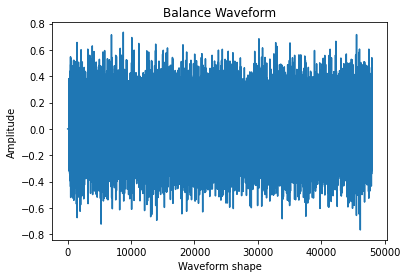

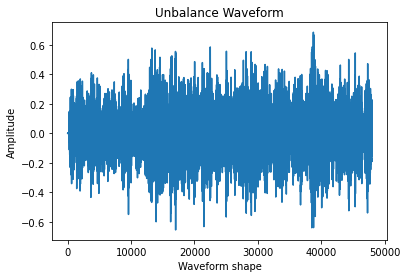

In [7]:
# Balance Waveform
timescale = np.arange(balance_waveform.shape[0])
plt.figsize=(12, 8)
plt.plot(timescale, balance_waveform.numpy())
plt.title("Balance Waveform")
plt.xlabel('Waveform shape')
plt.ylabel('Amplitude')
plt.show()

# Unbalance Waveform
timescale2 = np.arange(unbalance_waveform.shape[0])
plt.plot(timescale2, unbalance_waveform.numpy())
plt.title("Unbalance Waveform")
plt.xlabel('Waveform shape')
plt.ylabel('Amplitude')
plt.show()

## Step 3 - Preprocessing

### Spectrogram
A spectrogram shows the frequency spectrum of a signal as it changes over time, with color denoting amplitude.

In [8]:
def preprocess(waveform):
  # Make waveforms all equal lengths
  wav = waveform[:48000]
  # Padding for files with less than 48000 samples
  zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)

  # Padding all audio to the same length by concatenating
  waveform = tf.cast(waveform, tf.float32)
  wave_concat = tf.concat([waveform, zero_padding], 0)
  
  # Transform to Short-time Fourier transform (stft) by using tf.signal processing
  spectrogram = tf.signal.stft(wave_concat, frame_length=320, frame_step=64)
  spectrogram = tf.abs(spectrogram)

  return spectrogram

In [9]:
spectrogram_unbalance = preprocess(unbalance_waveform)

print('Label:', 'unbalance')
print('Waveform shape:', unbalance_waveform.shape)
print('Spectrogram shape:', spectrogram_unbalance.shape)
print('Audio playback')
ipd.Audio(unbalance_waveform.numpy(), rate=16000)

Label: unbalance
Waveform shape: (48000,)
Spectrogram shape: (746, 257)
Audio playback


In [10]:
spectrogram_balance = preprocess(balance_waveform)

print('Label:', 'balance')
print('Waveform shape:', balance_waveform.shape)
print('Spectrogram shape:', spectrogram_balance.shape)
print('Audio playback')
ipd.Audio(balance_waveform.numpy(), rate=16000)

Label: balance
Waveform shape: (48000,)
Spectrogram shape: (746, 257)
Audio playback


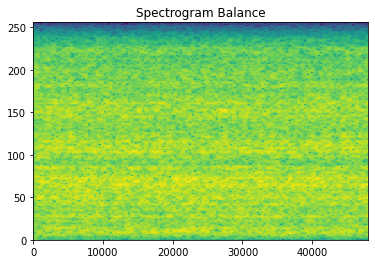

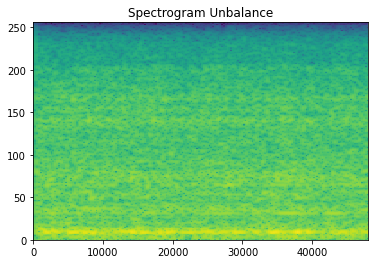

In [11]:
def spect_plot(spectrogram, ax, title):
    # Convert frequencies to log scale
    log_scale = np.log(spectrogram.T)
    height = log_scale.shape[0]
    width = log_scale.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_scale)
    ax.set_xlim([0, 48000])
    ax.set_title(title)
    
fig, ax = plt.subplots()  
spect_plot(spectrogram_balance.numpy(), ax, 'Spectrogram Balance')
plt.show()

fig, ax = plt.subplots()  
spect_plot(spectrogram_unbalance.numpy(), ax, 'Spectrogram Unbalance')
plt.show()

In [12]:
def create_spect_images(dataset, label_dir):
    # Make directory
    test_directory = os.makedirs(('./data/test/{}/'.format(label_dir)))
    train_directory = os.makedirs(('./data/train/{}/'.format(label_dir)))
    
    for i, data in enumerate(dataset):
        wave_form = data[0]
        spectrogram = preprocess(wave_form)
        # Split test and train images by 20%
        if i % 5 == 0:
            plt.imsave(f'./data/test/{label_dir}/spec_img{i}.png', 
                       spectrogram.numpy(), cmap='gray')
        else:
            plt.imsave(f'./data/train/{label_dir}/spec_img{i}.png', 
                       spectrogram.numpy(), cmap='gray')

In [13]:
create_spect_images(trainset_balance, 'balance')
create_spect_images(trainset_unbalance, 'unbalance')

In [14]:
import shutil
shutil.make_archive('/content/data', 'zip', '/content/data')

'/content/data.zip'

## Step 4 - Load Spectrogram images into a dataset for training

In [15]:
train_directory = './data/train/'
test_directory = './data/test/'

train_datagen = ImageDataGenerator(rescale=1./255,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = train_datagen.flow_from_directory(train_directory,
                                                    target_size=(256,256),
                                                    class_mode='binary')

test_generator = test_datagen.flow_from_directory(test_directory,
                                                    target_size=(256,256),
                                                    class_mode='binary')

Found 620 images belonging to 2 classes.
Found 156 images belonging to 2 classes.


## Step 5 - Training simple CNN classifier

### Create, compile, and train the model

In [16]:
model = tf.keras.Sequential([
  layers.Conv2D(16, 3, activation='relu', input_shape=(256, 256, 3)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

In [17]:
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)       0

###Callback
Callback allows to stop the training process when the desired accuracy is reached

In [19]:
class Callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if((logs.get('accuracy') > 0.98)):
            self.model.stop_training = True

Fit the model

In [20]:
# Train the model.
history = model.fit(train_generator, epochs=15, validation_data=test_generator, callbacks=[Callback()], verbose=1)

Epoch 1/15
20/20 [==============================] - 60s 3s/step - loss: 0.2755 - accuracy: 0.8823 - val_loss: 0.1867 - val_accuracy: 0.9103
Epoch 2/15
20/20 [==============================] - 52s 2s/step - loss: 0.1699 - accuracy: 0.9452 - val_loss: 0.1178 - val_accuracy: 0.9551
Epoch 3/15
20/20 [==============================] - 51s 3s/step - loss: 0.0860 - accuracy: 0.9677 - val_loss: 0.0570 - val_accuracy: 0.9808
Epoch 4/15
20/20 [==============================] - 50s 2s/step - loss: 0.0607 - accuracy: 0.9806 - val_loss: 0.0588 - val_accuracy: 0.9744


Text(0, 0.5, 'Accuracy [%]')

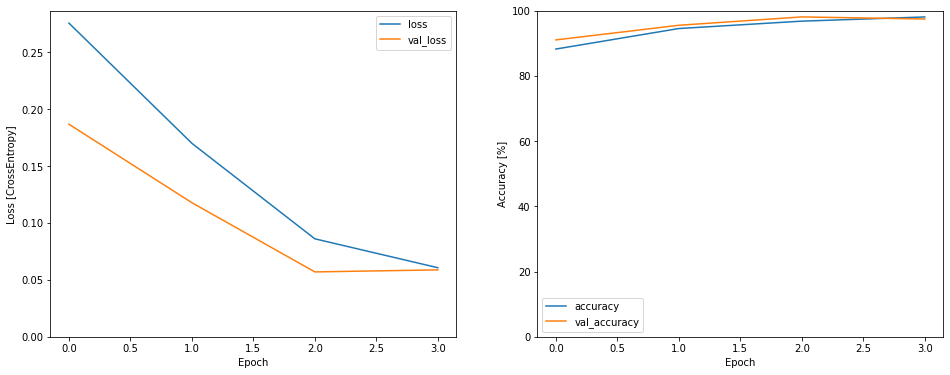

In [21]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 
         100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## Step 6 - Make a predictions




0.9743589758872986
(337711,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


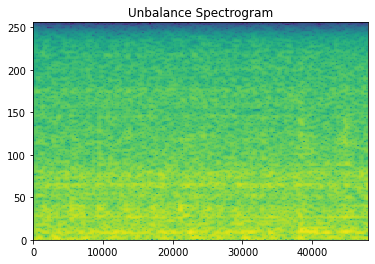

In [22]:
test_acc = model.evaluate(test_generator, verbose=0)
print(test_acc[1])

unbal_waveform, unbal_sample_rate = convert_audio('/content/unbalance_sample.wav')
print(unbal_waveform.shape)
ipd.Audio(unbal_waveform.numpy(), rate=16000)

unbal_spectrogram = preprocess(unbal_waveform)

fig, ax = plt.subplots()  
spect_plot(unbal_spectrogram.numpy(), ax, 'Unbalance Spectrogram')
plt.show()

In [23]:
unbal_path = '/content/spectrogram_sample.png'
plt.imsave(unbal_path, unbal_spectrogram.numpy(), cmap='gray')

unbal_pil_img = tf.keras.preprocessing.image.load_img(
    unbal_path, grayscale=False, color_mode='rgb', target_size=[256,256],
    interpolation='nearest')

unbal_pil_img

unbal_img_tensor = np.array(unbal_pil_img)
unbal_pred = model.predict(unbal_img_tensor[None,:,:])
unbal_predicted = np.argmax(unbal_pred)
unbal_string_result = 'balance' if unbal_predicted == 1 else 'unbalance'

print(f'Prediction for unbalance is {unbal_string_result}')

Prediction for unbalance is unbalance


In [24]:
# Save the model.
tf.keras.models.save_model(model, 'model.pbtxt')
converter = tf.lite.TFLiteConverter.from_keras_model(model=model) # path to the SavedModel directory
tflite_model = converter.convert()
open("model.tflite", "wb").write(tflite_model)

29590216